# Installing Dependencies

In [ ]:
!pip -q install langchain openai tiktoken chromadb pypdf sentence_transformers InstructorEmbedding faiss-cpu

# Importing Modules and performing initial setup

In [ ]:
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, OnlinePDFLoader, UnstructuredPDFLoader, DirectoryLoader
from langchain.chains import RetrievalQA
import os, sys

In [ ]:
os.environ['OPENAI_API_KEY'] = "ENTER_OPENAI_API_KEY"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


# Loading Source Data and storing its Vectored Representation locally

## Loading the Source Documents for the Knowledge Base

`pdfFilePath`: Path of the source directory containing *.pdf, *.txt, etc.

In [ ]:
pdfFilePath = "PATH_TO_THE_PDF_FILE"

Reading all the pdf files present in PATH `pdfFilePath` and using `load` method to extract "text" & "metadata" of pages

In [ ]:
DirLoader = DirectoryLoader(path=pdfFilePath, glob="*.pdf", loader_cls=PyPDFLoader)
documents = DirLoader.load()
print(f"Total number pages extracted from the documents: {len(documents)} \n")
print(f"Shown below is a document SNIPPET for reference: \n {documents[0]}")

Total number pages extracted from the documents: 41 

Shown below is a document SNIPPET for reference: 
 page_content=' \n \n \nGEM PRECARE  \nUSER MANUAL  \n  ' metadata={'source': '/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf', 'page': 0}


## Splitting source data into smaller chunks

Splitting extracted data into smaller chunks of documents (page_content & Page's metadata) because all LLMs models can process data upto a certain [token](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them) limit at once. 

In [ ]:
# Splitting data into smaller chunks so that only the required chunks are sent to the LLM as context
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
doc_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
doc_chunks = doc_splitter.split_documents(documents)
print(f"Number of doc_chunks: {len(doc_chunks)}")
print(f"Sample Chunk 0: \n``````````````` \n :{doc_chunks[0]}")
print(f"\n-------------------------------------------------\n")
print(f"Sample Chunk 1: \n``````````````` \n :{doc_chunks[1]}")

Number of doc_chunks: 61
Sample Chunk 0: 
``````````````` 
 :page_content='GEM PRECARE  \nUSER MANUAL' metadata={'source': '/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf', 'page': 0}

-------------------------------------------------

Sample Chunk 1: 
``````````````` 
 :page_content='GEM PRECARE User Manual    \n \n \n 2 \n \nGEM PRECARE User Manual  \nVersion 2.5  \nMarch 2021  \n© Copyright GEM 2021  \nThis software and documentation contain proprietary information of GEM and are provided under a \nlicense agreement containing restrictions on use and disclosure  and are also protected by copyright law. \nReverse engineering of the software is prohibited. No part of this document may be reproduced or \ntransmitted in any form, by any means (electronic, photocopying, recording or otherwise) without prior \nconsent of GEM . This Software may be protected by U.S. and/or international Patents and other Pate

**Alternatively**: Only the extracted text can be used for chunking

In [ ]:
# Extracting raw text from the documents
raw_text = ""
for doc in documents:
  text = doc.page_content
  if text:
    raw_text += text

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_chunks = text_splitter.split_text(raw_text)

print(f"Number of text_chunks: {len(text_chunks)}")
print(f"Sample Chunk 0: \n``````````````` \n :{text_chunks[0]}")
print(f"\n-------------------------------------------------\n")
print(f"Sample Chunk 1: \n``````````````` \n :{text_chunks[1]}")

Number of text_chunks: 49
Sample Chunk 0: 
``````````````` 
 :GEM PRECARE  
USER MANUAL  
  GEM PRECARE User Manual    
 
 
 2 
 
GEM PRECARE User Manual  
Version 2.5  
March 2021  
© Copyright GEM 2021  
This software and documentation contain proprietary information of GEM and are provided under a 
license agreement containing restrictions on use and disclosure  and are also protected by copyright law. 
Reverse engineering of the software is prohibited. No part of this document may be reproduced or 
transmitted in any form, by any means (electronic, photocopying, recording or otherwise) without prior 
consent of GEM . This Software may be protected by U.S. and/or international Patents and other Patents 
Pending.  
Use, duplication, or disclosure of the Software by the U.S. Government is subject to the restrictions set 
forth in the applicable software license agreement an d as provided in DFARS 227.7202 -1(a) and 
227.7702 -3(a) (1995), DFARS 252.227 -7013©(1)(ii) (OCT 1988), FAR 12

## Generating [embeddings](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) or encoding the Source Data  & storing the result in a `VectorStoreDB` locally

In [ ]:
# Instanciating an object of OpenAI Embeddings (check refrences for pricing)
embeddings = OpenAIEmbeddings()

In [ ]:
# Embedd and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = '/content/db'

vectordb = Chroma.from_documents(documents=doc_chunks, 
                                 embedding=embeddings,
                                 persist_directory=persist_directory)
vectordb.persist()

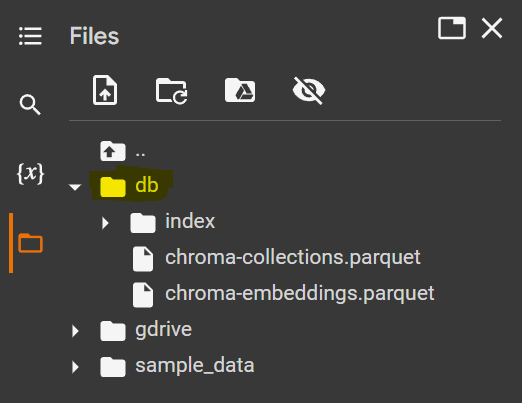

## Loading the Persisted `VectorStoreDB` from disk to memory

In [ ]:
persist_directory = '/content/db'

embeddings = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embeddings)

## Creating `retriever` Obj to extract relevant chunks from the `VectorStoreDB` based on query

In [ ]:
retriever = vectordb.as_retriever()

In [ ]:
query = "What does OEE Stands for?"
docs = retriever.get_relevant_documents(query)
docs

[Document(page_content='Figure 11: OEE Performance detail table  \nOEE Quality key indicators  \nAn example of these key indicators is shown in Figure 12. These key indicators  shows the total number \nof units produced, the total number of units that failed and the total number of units that passed, for \nthe specified time period.  \n \n \nFigure 12: OEE Quality detail table  \n3.1.2.2  Dynamic Analytics  \n \nAs part of the onboarding of each installat ion/ factory, the platform ingest a hierarchical model of it. \nWith that the GEM PRECARE platform processing engines, automatically correlate each data elements to \nits corresponding hierarchical level.', metadata={'source': '/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf', 'page': 14}),
 Document(page_content='GEM PRECARE User Manual    \n \n \n 4 \n \n \nAbbreviations  \nAcronym  Meaning  \nOEE Overall Equipment Effectiveness  \nOEE Utilization  Effe

In [ ]:
print(f"Count of relevant document chunks extracted: {len(docs)}")

Count of relevant document chunks extracted: 4


In [ ]:
# Reducing the number of chunks extracted to save cost. However, this could impact the Large Language Model (LLM) performnce
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

In [ ]:
# Technique used by retriever for document extraction
retriever.search_type

'similarity'

In [ ]:
retriever.search_kwargs

{'k': 2}

# Setting up QA Retrieval Chain

Instantiating the Large Language Model Object. However, this can be replaced with any opensource alternative.

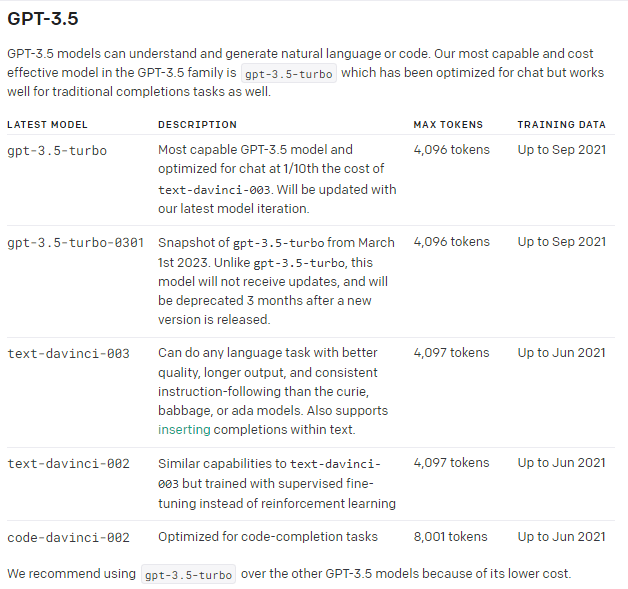

In [ ]:
llm=OpenAI()

In [ ]:
# create the chain to answer questions 
qa_chain = RetrievalQA.from_chain_type(llm=llm, 
                                  chain_type="stuff", 
                                  retriever=retriever, 
                                  return_source_documents=True,
                                  verbose=True)

Checking default `Prompt Template` for RetrievalQA chain

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


`{context}` : Top `k` ranked results by retriever

`{question}` : Query or question asked by the human

# Generating Response from the QA Retrieval Chain

In [ ]:
## Cite sources
def process_llm_response(llm_response):
    print(llm_response['result'])
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [ ]:
# full example
query = "What's the full form of OEE"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.
 Overall Equipment Effectiveness


Sources:
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf


In [ ]:
query = "What core idea behind GEM PRECARE?"
llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...

> Finished chain.
 GEM PRECARE offers manufacturers the ability to connect to legacy and new factory floor machinery and access critical operational data in real-time, with powerful analytics and predictive maintenance features to enable significant reductions in equipment downtime.


Sources:
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf
/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf


In [ ]:
# break it down
query = "What core idea behind GEM PRECARE?"
llm_response = qa_chain(query)
# process_llm_response(llm_response)
llm_response



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'What core idea behind GEM PRECARE?',
 'result': ' GEM PRECARE is a platform that offers manufacturers the ability to easily connect to legacy and new factory floor machinery and access critical operational multidimensional data in real-time. It combines powerful analytics and predictive maintenance capabilities with user-friendly dashboards. It also includes a wide variety of software agents and sensors tailored to specific types of machines, and can be used in a private, public or hybrid cloud configuration.',
 'source_documents': [Document(page_content='GEM PRECARE  \nUSER MANUAL', metadata={'source': '/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Milestone Project-PDF_Chatbot/data/pdfFiles/GEM_PRECARE_User_Manual_v2_54.pdf', 'page': 0}),
  Document(page_content='1 Overview  \n1.1 Introduction  \nThe GEM PRECARE platform offers manufacturers the abilit y to easily connect to legacy and new factory \nfloor machinery and access critical operational multi -dimensional (r

# APPENDIX

## Open Source Alternative

In [ ]:
import pickle
import faiss
from langchain.vectorstores import FAISS

In [ ]:
def store_embeddings(docs, embeddings, sotre_name, path):
    
    vectorStore = FAISS.from_documents(docs, embeddings)

    with open(f"{path}/faiss_{sotre_name}.pkl", "wb") as f:
        pickle.dump(vectorStore, f)

In [ ]:
def load_embeddings(sotre_name, path):
    with open(f"{path}/faiss_{sotre_name}.pkl", "rb") as f:
        VectorStore = pickle.load(f)
    return VectorStore

In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl", 
                                                      model_kwargs={"device": "cuda"})

/usr/local/lib/python3.10/dist-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


## References


- https://python.langchain.com/en/latest/reference/modules/embeddings.html
- https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/faiss.html
- https://python.langchain.com/en/latest/modules/indexes/vectorstores/getting_started.html
- https://cloud.google.com/dialogflow/pricing#es-agent
- https://github.com/imartinez/privateGPT
- https://www.logicloop.com/blog/using-chatgpt-to-help-you-write-sql-queries